## Regression formulation

Let's first treat the problem as a regression problem (output dimension = 1, MSE loss). 

In [1]:
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


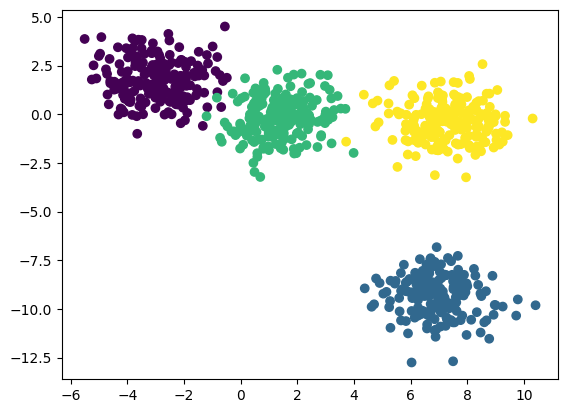

In [2]:
dataset = {}
X_all, y_all = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.0)
train_input, test_input, train_label, test_label = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:,None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:,None]).type(dtype).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())

Train KAN

In [3]:
model = KAN(width=[2,1], grid=3, k=3, device=device)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.23e-01 | test_loss: 2.59e-01 | reg: 2.97e+00 | : 100%|█| 20/20 [00:06<00:00,  3.17it

saving model version 0.1


(0.9574999809265137, 0.9549999833106995)

Automatic symbolic regression

In [4]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.9098681807518005, c=1
fixing (0,1,0) with sin, r2=0.9909113049507141, c=2
saving model version 0.2


0.2508*x_1 - 1.0389*sin(0.31*x_2 + 4.7017) + 0.2283

How accurate is this formula?

In [5]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.7837, device='cuda:0')
test acc of the formula: tensor(0.7600, device='cuda:0')


## Classification formulation

Let's then treat the problem as a classification problem (output dimension = 4, CrossEntropy loss). 

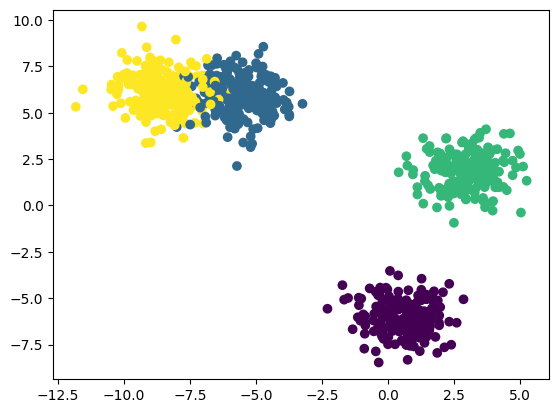

In [6]:

dataset = {}
X_all, y_all = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.0)
train_input, test_input, train_label, test_label = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

### Train KAN

In [7]:
model = KAN(width=[2,4], grid=3, k=3, seed=2024, device=device)

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.49e-01 | test_loss: 3.61e-01 | reg: 2.50e+02 | : 100%|█| 20/20 [00:04<00:00,  4.16it

saving model version 0.1


Automatic symbolic regression

In [8]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)
results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss())

fixing (0,0,0) with x, r2=0.04464099183678627, c=1
fixing (0,0,1) with sin, r2=0.9997418522834778, c=2
fixing (0,0,2) with sin, r2=0.9994804263114929, c=2
fixing (0,0,3) with sin, r2=0.9988683462142944, c=2
fixing (0,1,0) with sin, r2=0.9993670582771301, c=2
fixing (0,1,1) with sin, r2=0.9954116940498352, c=2
fixing (0,1,2) with sin, r2=0.997713029384613, c=2
fixing (0,1,3) with sin, r2=0.9927674531936646, c=2
saving model version 0.2


| train_loss: 2.52e-01 | test_loss: 3.51e-01 | reg: 0.00e+00 | : 100%|█| 20/20 [00:05<00:00,  3.52it

saving model version 0.3


In [9]:
formula1, formula2, formula3, formula4 = model.symbolic_formula()[0]
print(ex_round(formula1, 4))
print(ex_round(formula2, 4))
print(ex_round(formula3, 4))
print(ex_round(formula4, 4))


-0.7658*x_1 + 482.1096*sin(0.2*x_2 + 10.0) + 34.274
-262.2696*sin(0.2139*x_1 - 6.2774) - 438.0649*sin(0.1405*x_2 - 4.3398) + 207.4315
-288.6707*sin(0.276*x_1 - 2.6) - 176.4644*sin(0.245*x_2 + 3.29199981689453) + 3.7155
113.5869*sin(0.3301*x_1 - 2.1776) - 437.4864*sin(0.1396*x_2 + 8.2658) + 344.0119


In [10]:
print(train_acc())
print(test_acc())

tensor(0.9762, device='cuda:0')
tensor(0.9650, device='cuda:0')


How accurate is this formula?

In [11]:
# how accurate is this formula?
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

train acc of the formula: 0.0
test acc of the formula: 0.0


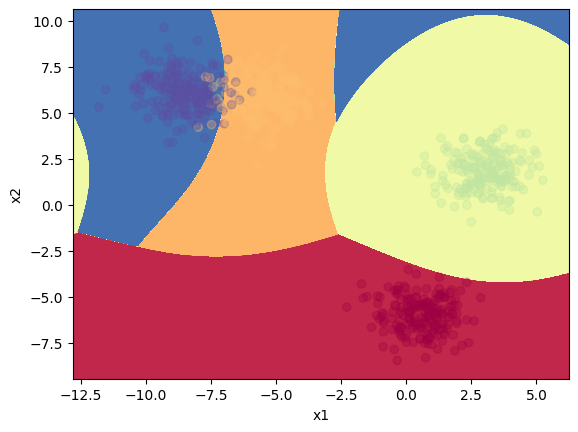

In [13]:
def plot_decision_boundary(model, X, y, h=0.01):
    X_cpu = X.cpu().detach()
    y_cpu = y.cpu().detach()
    x_min, x_max = X_cpu[:, 0].min() - 1, X_cpu[:, 0].max() + 1
    y_min, y_max = X_cpu[:, 1].min() - 1, X_cpu[:, 1].max() + 1
    xx, yy = torch.meshgrid(
        [torch.arange(x_min, x_max, h), torch.arange(y_min, y_max, h)]
    )
    grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)
    grid = grid.to(X.device)
    Z = model(grid)
    Z = Z.argmax(dim=1).reshape(xx.shape).cpu()
    plt.contourf(xx.cpu(), yy.cpu(), Z, cmap=plt.cm.Spectral)
    plt.scatter(X_cpu[:, 0], X_cpu[:, 1], c=y_cpu, cmap=plt.cm.Spectral, alpha=0.1)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.show()

plot_decision_boundary(model, X, y)